In [1]:
import snowflake.connector
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import sys
from tcn import compiled_tcn
from sklearn.metrics import mean_squared_error
import datetime, time
%matplotlib inline
import plotly.graph_objects as go
from sklearn import preprocessing
from datetime import datetime
from snowflake.sqlalchemy import URL 
from sqlalchemy import create_engine 
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
thesis_data = pd.read_csv('pressure_data_finalized.csv', )

In [3]:
thesis_data.shape

(26800, 2)

In [4]:
thesis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26800 entries, 0 to 26799
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         26800 non-null  object 
 1   PT0102[Bar]  26800 non-null  float64
dtypes: float64(1), object(1)
memory usage: 418.9+ KB


In [5]:
thesis_data

date  PT0102[Bar]
0      2023-04-13 08:11:17.287         3.09
1      2023-04-13 08:11:17.387         3.09
2      2023-04-13 08:11:17.487         3.27
3      2023-04-13 08:11:17.587         3.56
4      2023-04-13 08:11:17.687         3.79
...                        ...          ...
26795  2023-04-13 08:55:56.787         3.45
26796  2023-04-13 08:55:56.887         3.43
26797  2023-04-13 08:55:56.987         3.44
26798  2023-04-13 08:55:57.087         3.48
26799  2023-04-13 08:55:57.187         3.34

[26800 rows x 2 columns]

In [6]:
print(thesis_data['date'].min()+ ' --- ' +  thesis_data['date'].max())


# Normal data until #08:43:44.687

# After that abnormal data

2023-04-13 08:11:17.287 --- 2023-04-13 08:55:57.187


In [7]:
# All the data
# 26800 data points

fig = go.Figure()

# Create Line plot
fig.add_trace(go.Scatter( x = thesis_data["date"], y = thesis_data["PT0102[Bar]"], mode='lines', name = 'pressure'))

# Display the plot
fig.show()





In [8]:
# Normal data
# There are 19475 normal data points
# At this point, air pressure was present in the Pump
normal_data_mask = (thesis_data['date'] >= '2023-04-13 08:11:17.287') & (thesis_data['date'] <= '2023-04-13 08:43:44.687')
thesis_data[normal_data_mask].shape

(19475, 2)

In [9]:
# Plotting the normal data
# There are cycles visible in the data
fig = go.Figure()

# Create Line plot
fig.add_trace(go.Scatter( x = thesis_data[normal_data_mask]["date"], y = thesis_data[normal_data_mask]["PT0102[Bar]"], mode='lines', name = 'pressure'))

# Display the plot
fig.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import tensorflow as tf

# Step 1: Load and preprocess the data
# Loading data and preprocess it as needed

thesis_data = pd.read_csv('pressure_data_finalized.csv', parse_dates=True, index_col="date")

# Split data into normal and abnormal datasets
df_training_value = thesis_data[:17175]
df_test_value = thesis_data[17175:]

In [11]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_training_value)
scaled_test = scaler.transform(df_test_value)


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_windows(data, window_size, prediction_horizon=1):
    """
    Transforms time series data into input-output pairs.
    """
    x, y = [], []
    for i in range(len(data) - window_size - prediction_horizon + 1):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + prediction_horizon])
    x, y = np.array(x), np.array(y)

    # If predicting only one future value, reshape y to have 2D shape
    if prediction_horizon == 1:
        y = y.reshape(-1, 1)
    return x, y

window_size = 132
prediction_horizon = 1  # predict just the next value


# Create windows for the scaled data
x_train, y_train = create_windows(scaled_train, window_size, prediction_horizon)
x_test, y_test = create_windows(scaled_test, window_size, prediction_horizon)



In [63]:

def build_mlp_model(num_hidden_units, input_shape, dropout_rate):
    model = Sequential()
    
    # Initial dense layer
    model.add(Dense(units=132, activation='relu', input_dim=input_shape))
    
    # Additional hidden layers with dropout
    for _ in range(2):  # This will create 2 additional hidden layers as per your original model
        model.add(Dense(units=num_hidden_units, activation='relu'))
        #model.add(Dropout(dropout_rate))
    model.add(Dense(units=32, activation='relu'))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error')
    
    return model

# Set hyperparameters
TIME_STEPS = 132  # Define the input shape here
num_hidden_units = 64
dropout_rate = 0.1
learning_rate = 0.001
batch_size = 64 

model = build_mlp_model(num_hidden_units, TIME_STEPS, dropout_rate)
model.summary()


# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=20, 
    validation_split=0.2,  # use 20% of the data as validation data
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 132)               17556     
                                                                 
 dense_23 (Dense)            (None, 64)                8512      
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 32,341
Trainable params: 32,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
214/214 [==============================

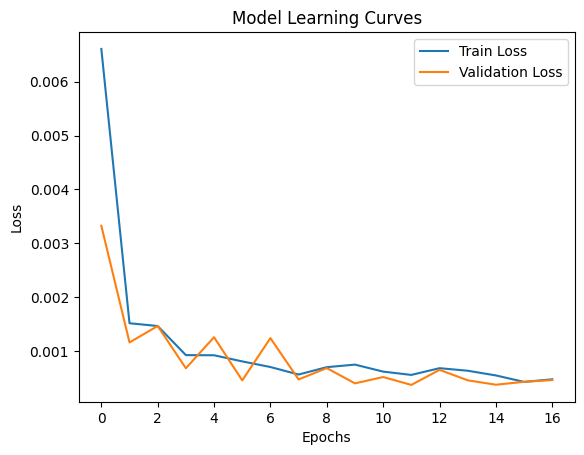

In [64]:
def plot_learning_curves(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

plot_learning_curves(history)

In [65]:
def plot_confusion_matrix(matrix, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Add labels
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           xlabel='Predicted',
           ylabel='True')
    
    # Add counts to heatmap
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, matrix[i, j], ha='center', va='center', color='w')
    
    plt.show()

    


# Making predictions on the test data
y_pred_scaled = model.predict(x_test)

# If you want the predictions in the original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Errors can be calculated in the scaled or original space, depending on your needs
errors = np.abs(y_pred - y_test_original)

297/297 [==============================] - 1s 2ms/step


In [66]:

# Making predictions on the training data to determine the threshold
y_train_pred = model.predict(x_train)

# If you want the predictions in the original scale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_original = scaler.inverse_transform(y_train)

train_errors = np.abs(y_train_pred - y_train_original)

threshold = np.mean(train_errors) + 3 * np.std(train_errors)
threshold
#threshold = np.max(train_errors)  # Only 3 anomalies


533/533 [==============================] - 1s 2ms/step


0.05567130003953452

In [67]:
anomalies = np.where(errors > threshold)
anomalies

(array([  73,   74,  202, ..., 9488, 9490, 9491], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

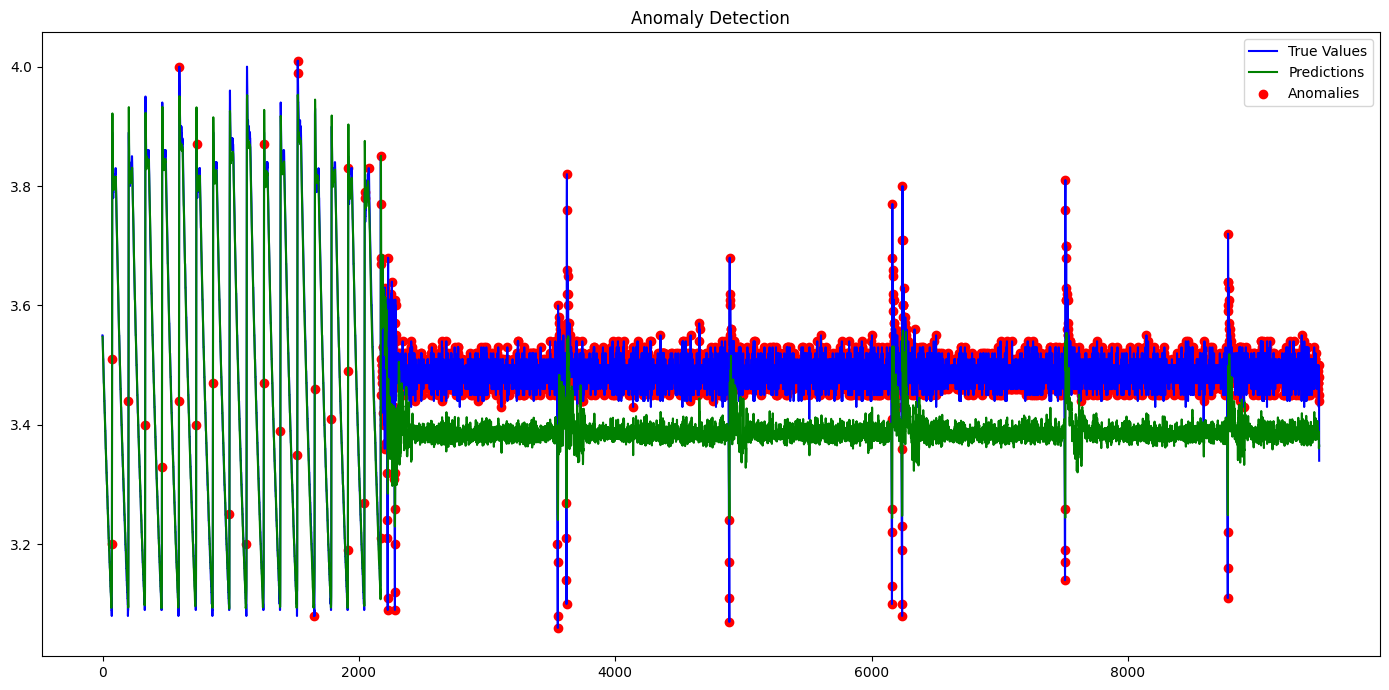

In [68]:

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plotting the actual test values
plt.plot(y_test_original, label='True Values', color='blue')

# Plotting the predicted values
plt.plot(y_pred, label='Predictions', color='green')

# Extract indices from the anomalies tuple
anomaly_indices = anomalies[0]

# Highlighting the anomalies
plt.scatter(anomaly_indices, y_test_original[anomaly_indices], color='red', label='Anomalies')

plt.title('Anomaly Detection')
plt.legend()
plt.tight_layout()
plt.show()

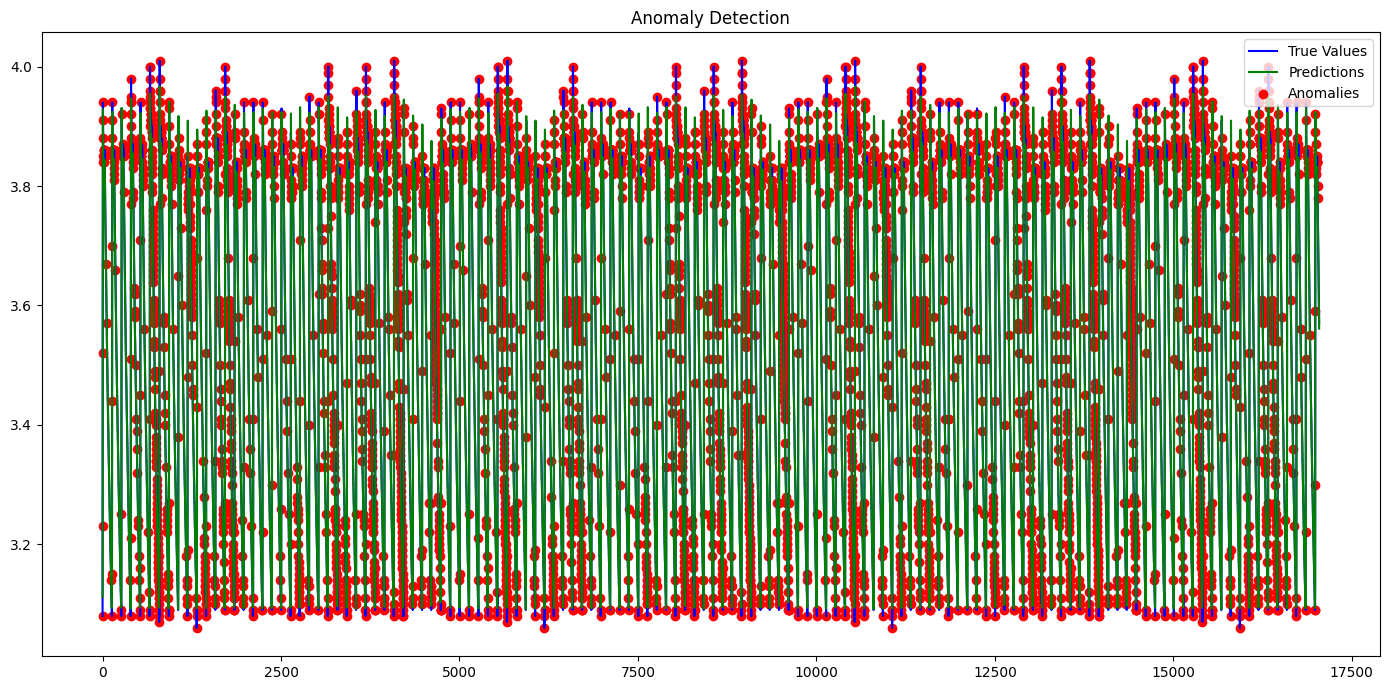

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plotting the actual test values
plt.plot(y_train_original, label='True Values', color='blue')

# Plotting the predicted values
plt.plot(y_train_pred, label='Predictions', color='green')


anomalies = np.where(train_errors >  np.mean(train_errors) )
anomalies

# Extract indices from the anomalies tuple
anomaly_indices = anomalies[0]


# Highlighting the anomalies
plt.scatter(anomaly_indices, y_train_original[anomaly_indices], color='red', label='Anomalies')

plt.title('Anomaly Detection')
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
y_pred.shape

(9493, 1)

In [71]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

y_pred_labels = np.where(errors > threshold, 1, 0)
y_true_labels =  np.concatenate((np.zeros((2300, 1)), np.ones((7193, 1))), axis=0).astype(int)  # 1 for normal, 0 for anomaly

accuracy = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels)
recall = recall_score(y_true_labels, y_pred_labels)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precison: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.9386
F1 Score: 0.9586
Precison: 0.9805
Recall: 0.9376


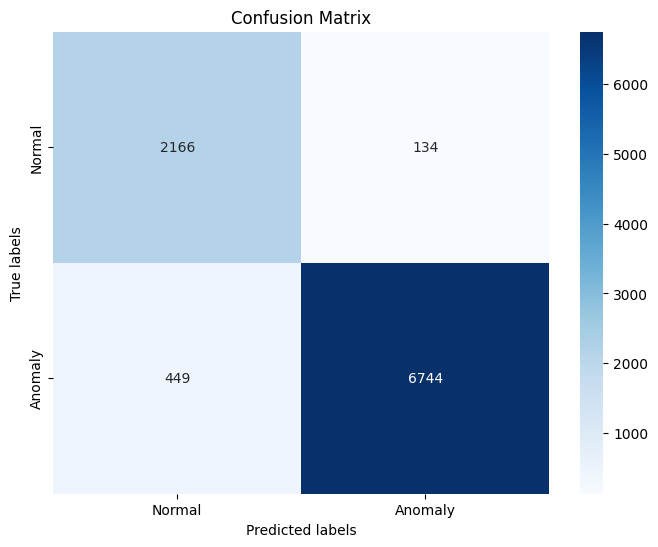

In [72]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
